# Additional Data Creator Workbook

In [26]:
# Import the relevent packages
import os # File/directory operations
import ntpath # File/directory operations
import imgaug as ia # Image augmentations
import imgaug.augmenters as iaa # Image augmentations
import imageio as imio # Reading images
import numpy as np # Matrix operations
from skimage import data # Image operations
from skimage.color import rgb2gray # RGB image to grey
from skimage.transform import resize # Resize images
import matplotlib.pyplot as plt # for visualisation
import pandas as pd # Data manipulations
from scipy import stats #not used but helps with debuging
from tqdm import tqdm # Progress bar
import warnings # Hide warnings in jupyter
warnings.filterwarnings('ignore')

In [27]:
# Set the input and output paths for later reference
dataPaths = {'InputImageTrain':os.path.abspath(os.path.join('Data','Train','Images',)),
             'InputAnnotTrain':os.path.abspath(os.path.join('Data','Train','Annotations')),
             'InputImageTest':os.path.abspath(os.path.join('Data','Test','Images')),
             'InputAnnotTest':os.path.abspath(os.path.join('Data','Test','Annotations')),
             'OutputImageTrain':os.path.abspath(os.path.join('Output','Train','Images')),
             'OutputAnnotTrain':os.path.abspath(os.path.join('Output','Train','Annotations')),
             'OutputImageTest':os.path.abspath(os.path.join('Output','Test','Images')),
             'OutputAnnotTest':os.path.abspath(os.path.join('Output','Test','Annotations')),
             'XTrain':os.path.abspath(os.path.join('OutputData','XTrain')),
             'yTrain':os.path.abspath(os.path.join('OutputData','yTrain')),
             'XTest':os.path.abspath(os.path.join('OutputData','XTest')),
             'yTest':os.path.abspath(os.path.join('OutputData','yTest'))}

In [28]:
def getFilesInDir(dir):
    """This function will return a list of files in the given dir"""
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(dir):
        for file in f:
            files.append(os.path.join(r, file))
    return files

def validateImagePairs(imPairTuple, width):
    """This function reads the image and resizes it to the closest %32=0 for the specified width"""
    imgDir , annotDir = imPairTuple
    img = imio.imread(imgDir)
    annot = rgb2gray(imio.imread(annotDir))*255
    
    widthScaleRatio = width / img.shape[1]
    heightNew = (widthScaleRatio * (img.shape[0]))
    heightNew = heightNew - (heightNew%32)
    
    annotNew = resize(annot, (heightNew, width),mode='edge', anti_aliasing=False,
                               anti_aliasing_sigma=None,preserve_range=True,
                               order=0).astype(int)
    df = (pd.DataFrame(annotNew))
    _, b = pd.factorize(df.values.T.reshape(-1, ))  

    # print(df.apply(lambda x: pd.Categorical(x, b).codes).values.shape)
    annotNewOut = df.apply(lambda x: pd.Categorical(x, b).codes).values
    
    
    return (resize(img, (heightNew, width), anti_aliasing=True),
            annotNewOut)

def augment_seg(imSegTuple, filterSeq):
    """This function applies a 'filter' to the input image and its annotation """
    img , seg = imSegTuple  
    img = img*255
    img = img.astype(np.uint8)
    aug_det = filterSeq.to_deterministic() 
    image_aug = aug_det.augment_image( img )
    segmap = ia.SegmentationMapOnImage( seg , nb_classes=len(np.unique(seg)), shape=img.shape )
    segmap_aug = aug_det.augment_segmentation_maps( segmap )
    segmap_aug = segmap_aug.get_arr_int()
    return (image_aug , segmap_aug)

def path_leaf(path):
    """This function gets the file name from a path"""
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def saveAugmentOutputs(augmentImagePairs, originalFileNamePairs, suffex, outImagPath, outAnnotPath):
    """This function saves the augmented images"""
    for i in range(0, len(augmentImagePairs)):
        img = augmentImagePairs[i][0]
        fileName = path_leaf(originalFileNamePairs[i][0])
        fileNameSplit = fileName.split('.')
        imFileName = outImagPath+'\\'+fileNameSplit[0]+suffex+'.'+fileNameSplit[1]
        imio.imsave(imFileName, img)
        #print(imFileName)
        annot = augmentImagePairs[i][1]
        annot = flattenSegImage(annot,getSegClasses(annot))
        fileNameAnnot = path_leaf(originalFileNamePairs[i][1])
        fileNameAnnotSplit = fileNameAnnot.split('.')
        annotFileName = outAnnotPath+'\\'+fileNameAnnotSplit[0]+suffex+'.'+fileNameAnnotSplit[1]
        annot = annot.astype(np.uint8)
        imio.imwrite(annotFileName, annot)

def ShowAugmentCompare(originalTup, newTup):
    """This function shows a comparason of orginal vs augmented images and annotations"""
    fig, axes = plt.subplots(nrows=2, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(originalTup[0])
    ax[0].set_title("Original image")
    ax[1].imshow(newTup[0])
    ax[1].set_title("New image")
    ax[2].imshow(originalTup[1], cmap='gray')
    ax[2].set_title("Original annotation")
    ax[3].imshow(newTup[1], cmap='gray')
    ax[3].set_title("New annotation")
    plt.tight_layout()
    plt.show()
    

def getSegClasses(seg):
    segUnique = np.unique(seg)
    #print(segUnique)
    output = {}
    for i in range(0,len(segUnique)):
        output[segUnique[i]] = i
    return output
        
    
def flattenSegImage(seg, classes):
    k = np.array(list(classes.keys()))
    v = np.array(list(classes.values()))
    sidx = k.argsort()
    output = v[sidx[np.searchsorted(k,seg,sorter=sidx)]]
    
    #print(stats.describe(seg).mean)
    #print(stats.describe(output).mean)
    return output

def processImages(filterCol, inputImagePairs, filePairPaths, dataPathImg, dataPathAnnot):    
    for key, value in tqdm(filterCol.items()):
        if(value==None):
            #print(key)
            saveAugmentOutputs(inputImagePairs, filePairPaths, key, dataPathImg, dataPathAnnot)
        else:
            #print('Applying filter \''+ key +'\' to input')
            outputAugment = []
            for tup in inputImagePairs:
                outputAugment.append(augment_seg(tup, value))
            #print('Saving output of filter \''+ key +'\'')
            saveAugmentOutputs(outputAugment, filePairPaths, key, dataPathImg, dataPathAnnot)


In [38]:
# This will create a list of tuples for the input images, it will associate an image with 
# its annotation given the naming convention is followed

print('Reading and resizing input files...')

WIDTH = 416

filePairPathsTrain = list(zip(getFilesInDir(dataPaths['InputImageTrain']), getFilesInDir(dataPaths['InputAnnotTrain'])))
inputImagePairsTrain = []
for tup in filePairPathsTrain:
    inputImagePairsTrain.append(validateImagePairs(tup,WIDTH))
    
print('Train: Read '+str(len(inputImagePairsTrain)*2)+' files.')

filePairPathsTest = list(zip(getFilesInDir(dataPaths['InputImageTest']), getFilesInDir(dataPaths['InputAnnotTest'])))
inputImagePairsTest = []
for tup in filePairPathsTest:
    inputImagePairsTest.append(validateImagePairs(tup,WIDTH))
    
print('Test: Read '+str(len(inputImagePairsTest)*2)+' files.')

Reading and resizing input files...
Train: Read 28 files.
Test: Read 14 files.


In [39]:
# See https://github.com/aleju/imgaug#example-images for details

print('Createing filters...')

### Expriment 1, 2, 3
filters1 = {
    'a':None
}

### Expriment 4, 5, 6
filters4 = {
    'a':None,
    'b':iaa.Sequential([iaa.MotionBlur(k=5,angle=[-90, 90]),]), # horizontally flip ,
    'c':iaa.Sequential([iaa.Fliplr(1),]), # horizontally flip ,
    'd':iaa.Sequential([iaa.Flipud(1),]), # vertically flip ,
    'e':iaa.Sequential([iaa.PerspectiveTransform(scale=0.01, keep_size=True),]),# Perspective Transform,
    'f':iaa.Sequential([iaa.PiecewiseAffine(scale=0.01),]),# Piecewise Affine
    'g':iaa.Sequential([iaa.Multiply((0.9, 1.1)),]),# Make image brighter/darker
    'h':iaa.Sequential([iaa.AddToHueAndSaturation((-10, 10)),iaa.PiecewiseAffine(scale=0.01), iaa.PerspectiveTransform(scale=0.01, keep_size=True)]),# Shift the hue,
    'i':iaa.Sequential([iaa.MotionBlur(k=5,angle=[-90, 90]),iaa.Fliplr(1),iaa.AddToHueAndSaturation((-10, 10))]),
    'j':iaa.Sequential([iaa.MotionBlur(k=5,angle=[-90, 90]),iaa.Fliplr(1),iaa.Flipud(1)]),
    'k':iaa.Sequential([iaa.MotionBlur(k=5,angle=[-90, 90]),iaa.Fliplr(1),iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.01, keep_size=True)]),
    'l':iaa.Sequential([iaa.Fliplr(1),iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.01, keep_size=True),iaa.PiecewiseAffine(scale=0.01)]),
    'm':iaa.Sequential([iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.01, keep_size=True),iaa.PiecewiseAffine(scale=0.01),iaa.GammaContrast((0.9, 1.1))]),
    'n':iaa.Sequential([iaa.PerspectiveTransform(scale=0.01, keep_size=True),iaa.PiecewiseAffine(scale=0.01),iaa.GammaContrast((0.9, 1.1)),iaa.AddToHueAndSaturation((-10, 10))]),
    'o':iaa.Sequential([iaa.PiecewiseAffine(scale=0.01),iaa.AddToHueAndSaturation((-10, 10))]),
    'p':iaa.Sequential([iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.01, keep_size=True),iaa.PiecewiseAffine(scale=0.01),iaa.AddToHueAndSaturation((-10, 10))]),
    'q':iaa.Sequential([iaa.Fliplr(1),iaa.AddToHueAndSaturation((-10, 10))]),
    'r':iaa.Sequential([iaa.MotionBlur(k=5,angle=[-90, 90]),iaa.PerspectiveTransform(scale=0.01, keep_size=True),iaa.GammaContrast((0.9, 1.1)),iaa.AddToHueAndSaturation((-10, 10))]),
    's':iaa.Sequential([iaa.Fliplr(1),iaa.Flipud(1), iaa.GammaContrast((0.9, 1.1)),iaa.AddToHueAndSaturation((-10, 10))]),
    't':iaa.Sequential([iaa.Fliplr(1),iaa.Flipud(1), iaa.PiecewiseAffine(scale=0.01),iaa.AddToHueAndSaturation((-10, 10))]),
    'u':iaa.Sequential([iaa.Fliplr(1),iaa.Flipud(1), iaa.PerspectiveTransform(scale=0.01, keep_size=True),iaa.Multiply((0.9, 1.1))]),
    'v':iaa.Sequential([iaa.MotionBlur(k=5,angle=[-90, 90]),iaa.AddToHueAndSaturation((-10, 10))]),
    'w':iaa.Sequential([iaa.Flipud(1),iaa.PerspectiveTransform(scale=0.01, keep_size=True)]),
    'x':iaa.Sequential([iaa.Fliplr(1),iaa.AddToHueAndSaturation((-10, 10))]),
    'y':iaa.Sequential([iaa.PiecewiseAffine(scale=0.01),iaa.GammaContrast((0.9, 1.1))]),
    'z':iaa.Sequential([iaa.MotionBlur(k=5,angle=[-90, 90]),iaa.PerspectiveTransform(scale=0.01, keep_size=True),iaa.GammaContrast((0.9, 1.1)),iaa.AddToHueAndSaturation((-10, 10))])
}

print(filters4)

Createing filters...


{'a': None, 'b': Sequential(name=UnnamedSequential, random_order=False, children=[Convolve(name=UnnamedMotionBlur, parameters=[<function MotionBlur.<locals>.create_matrices at 0x0000018C284E7510>, function], deterministic=False)], deterministic=False), 'c': Sequential(name=UnnamedSequential, random_order=False, children=[Fliplr(name=UnnamedFliplr, parameters=[Deterministic(int 1)], deterministic=False)], deterministic=False), 'd': Sequential(name=UnnamedSequential, random_order=False, children=[Flipud(name=UnnamedFlipud, parameters=[Deterministic(int 1)], deterministic=False)], deterministic=False), 'e': Sequential(name=UnnamedSequential, random_order=False, children=[PerspectiveTransform(name=UnnamedPerspectiveTransform, parameters=[Normal(loc=Deterministic(int 0), scale=Deterministic(float 0.01000000)), True, Deterministic(int 0), Deterministic(constant)], deterministic=False)], deterministic=False), 'f': Sequential(name=UnnamedSequential, random_order=False, children=[PiecewiseAffin

In [40]:
print('Processing train images')
processImages(filters4, inputImagePairsTrain, filePairPathsTrain, dataPaths['OutputImageTrain'],dataPaths['OutputAnnotTrain'])

print('Processing test images')
processImages(filters4, inputImagePairsTest, filePairPathsTest, dataPaths['OutputImageTest'],dataPaths['OutputAnnotTest'])

Processing train images


  0%|                                                                                           | 0/26 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Processing test images


  0%|                                                                                           | 0/26 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
100%|███████████████████████████████████████████

In [41]:
from sklearn.model_selection import train_test_split # setting up the test and train data

print('Spilliting train and test sets')
fileOutputPathsTrain = list(zip(getFilesInDir(dataPaths['OutputImageTrain']),
                                getFilesInDir(dataPaths['OutputAnnotTrain'])))
dfTrain = pd.DataFrame(fileOutputPathsTrain, columns=['X', 'y'])
X_train = dfTrain['X']
y_train = dfTrain['y']

fileOutputPathsTest = list(zip(getFilesInDir(dataPaths['OutputImageTest']),
                                getFilesInDir(dataPaths['OutputAnnotTest'])))
dfTest = pd.DataFrame(fileOutputPathsTest, columns=['X', 'y'])
X_test = dfTest['X']
y_test = dfTest['y']

Spilliting train and test sets


In [42]:
from shutil import copyfile
import errno

def copyFileToDir(df, path):
    for file in df.values:
        print(file)
        dest = path+'\\'
        print(dest)
        dest = dest+path_leaf(file)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        copyfile(file, dest)

In [43]:
print('Copying train/test output')
copyFileToDir(X_train,dataPaths['XTrain'])
copyFileToDir(X_test,dataPaths['XTest'])
copyFileToDir(y_train,dataPaths['yTrain'])
copyFileToDir(y_test,dataPaths['yTest'])

Copying train/test output
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\1001a.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\1001b.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\1001c.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\1001d.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\2001i.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\2001j.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\2001k.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\2001l.jpg
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\3001p.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\3001q.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\3001r.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\3001s.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\4001x.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\4001y.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\4001z.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\5001a.jpg
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\5007e.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\5007f.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\5007g.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\5007h.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\6001m.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\6001n.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\6001o.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\6001p.jpg
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\6010t.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\6010u.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\6010v.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\6010w.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\7004b.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\7004c.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\7004d.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\7004e.jpg
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\7010i.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\7010j.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\7010k.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\7010l.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\8001q.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\8001r.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\8001s.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\8001t.jpg
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\8005x.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\8005y.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\8005z.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Images\8007a.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTrain\
C:\Users\theza\Documents\Uni

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\1005f.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\1005g.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\1005h.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\1005i.jpg
C:\Users\theza\Documents\Uni\MIT\201

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\2002m.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\2002n.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\2002o.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\2002p.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\201

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\3004u.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\3004v.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\3004w.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\3004x.jpg
C:\Users\theza\Documents\Uni\MIT\201

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\5006b.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\5006c.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\5006d.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\5006e.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\201

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\6004j.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\6004k.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\6004l.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\6004m.jpg
C:\Users\theza\Documents\Uni\MIT\201

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\8006q.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\8006r.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\8006s.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Images\8006t.jpg
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\XTest\
C:\Users\theza\Documents\Uni\MIT\201

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\1001x.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\1001y.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\1001z.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\2001a.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\3001e.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\3001f.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\3001g.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\3001h.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\4001l.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\4001m.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\4001n.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\4001o.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\5001s.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\5001t.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\5001u.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\5001v.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\5007z.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\6001a.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\6001b.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\6001c.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\6010g.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\6010h.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\6010i.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\6010j.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\7001n.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\7001o.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\7001p.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\7001q.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\7004u.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\7004v.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\7004w.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\7004x.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8001b.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8001c.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8001d.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8001e.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8005i.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8005j.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8005k.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8005l.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8007p.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8007q.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8007r.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Train\Annotations\8007s.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTrain\
C:\Users

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\1005w.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\1005x.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\1005y.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\1005z.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\D

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\3004d.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\3004e.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\3004f.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\3004g.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\D

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\4002k.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\4002l.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\4002m.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\4002n.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\D

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\5006r.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\5006s.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\5006t.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\5006u.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\D

C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\6004y.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\6004z.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\8006a.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\Output\Test\Annotations\8006b.png
C:\Users\theza\Documents\Uni\MIT\2019\TP\Project\Meal-Compliance-Project\Additional-Data-Creator\OutputData\yTest\
C:\Users\theza\D

[0 1 2 3 4 5 6 7 8 9]


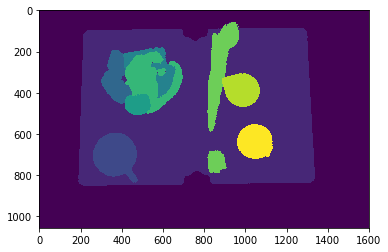

In [12]:
img = imio.imread('1a.png')
print(np.unique(img))
plt.imshow(img)